# Quantum Tunelling Implementation

This notebook will start with the simple case of two qubits. Note that this means we have $n=2$, so we have discretized the space into $2^2 = 4$ sections: $|00 \rangle, |01 \rangle, |10 \rangle, |11 \rangle$.  

In [72]:
import numpy as np
import numpy.linalg as la
import math as m
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
#from qiskit_textbook.tools import random_state, array_to_latex # This import isn't working for me

import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.14.1', 'qiskit-aer': '0.5.2', 'qiskit-ignis': '0.3.0', 'qiskit-ibmq-provider': '0.7.2', 'qiskit-aqua': '0.7.1', 'qiskit': '0.19.3'}


# Aden's Notes

(The following image is taken from Aden's slides)

Our goal is the produce the following gate into a circuit:

<img src="Tunelling Images/kinetic gate.png">


The matrix above represents our kinetic time evolution operator once we are in the QFTed basis. This kinetic term can be broken down into the following gates.

<img src="Tunelling Images/gates.png">

Note that the first and the last block of gates is simply the quantum fourier transforms and inverses.

**Although Qiskit does numbering in the opposite order (0 on the top row, then 1, then 2, etc.) I will follow this picture exactly.**

<img src="Tunelling Images/3 decomp.png">


<img src="Tunelling Images/D gate.png">

We will first try the case with $\Delta t = 1/\pi \approx 0.318$. Then, we can use the values given above

In [73]:
#I will start by defining functions for the quantum fourier transform (and inverse), potential, and D term
# in the image above, 1 -> 1, and 2 -> 0

# Setting th parameters for the system
delta_t = 3 / 10 
#I checked 2/10, 3/10, and 5/10
theta1 = -m.pi*m.pi*delta_t
theta2 = -m.pi*m.pi*delta_t/4
theta3 = m.pi*m.pi*delta_t

def F(qc):
    qc.h(1)
    qc.cu1(m.pi/2, 0, 1)
    qc.h(0)
    qc.barrier()
    return qc

def F_inv(qc):
    qc.h(0)
    qc.cu1(-m.pi/2, 0, 1)
    qc.h(1)
    qc.barrier()
    return qc    

def D(qc, theta1, theta2, theta3):
    qc.rz(theta1, 0)
    qc.rz(theta2, 1)
    qc.cu1(theta3, 1,0)
    qc.barrier()
    return qc
    


In [74]:
# Using Aden's notes, I will try a free particle simulation

# Initializing the circuit
qr = QuantumRegister(2) #the qubits needed
cr = ClassicalRegister(2) #for the measurement
qc = QuantumCircuit(qr, cr) #creating the quantum circuit
qc.x(0)
F(qc)
D(qc, theta1, theta2, theta3)
F_inv(qc)
qc.measure( qr , cr )

qc.draw()

┌───┐       ┌───┐ ░ ┌─────────────┐           ░ ┌───┐              ░ ┌─┐»
q33_0: ┤ X ├─■─────┤ H ├─░─┤ RZ(-2.9609) ├──■────────░─┤ H ├─■────────────░─┤M├»
       ├───┤ │pi/2 └───┘ ░ ├─────────────┴┐ │2.9609  ░ └───┘ │-pi/2 ┌───┐ ░ └╥┘»
q33_1: ┤ H ├─■───────────░─┤ RZ(-0.74022) ├─■────────░───────■──────┤ H ├─░──╫─»
       └───┘             ░ └──────────────┘          ░              └───┘ ░  ║ »
c33_0: ══════════════════════════════════════════════════════════════════════╩═»
                                                                               »
c33_1: ════════════════════════════════════════════════════════════════════════»
                                                                               »
«          
«q33_0: ───
«       ┌─┐
«q33_1: ┤M├
«       └╥┘
«c33_0: ═╬═
«        ║ 
«c33_1: ═╩═
«

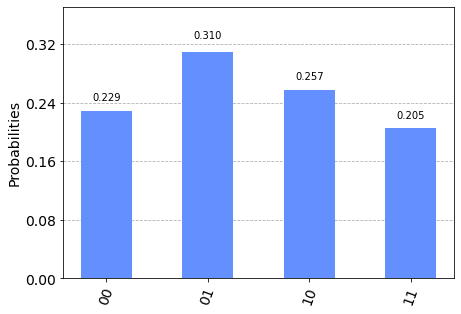

In [75]:

backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
counts = execute(qc, backend, shots=1024).result().get_counts()

"""
vector = np.zeros(len(counts))

ordering = {'00': 0, '01': 1, '10':2, '11':3}
for key in counts.keys():
    print(key) #printing the key to check the order
    vector[ordering[key]] = counts[key]
    
vector = vector / 1024
print(vector)

density_matrix = np.outer(vector, vector)
print(density_matrix)
"""

plot_histogram(counts)

## Implementing V

We will now try to implent a potential operator. Recall that:

$$ R_\phi = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\phi}\end{bmatrix} $$

We know that we can write the potential operator as:

<img src="Tunelling Images/V gate.png">

Consider the operation $ I \otimes R_\phi $

$$ I \otimes R_\phi = \begin{bmatrix}  1 & 0 \\ 0 & 1 \end{bmatrix}\otimes \begin{bmatrix}  1 & 0 \\ 0 & e^{i\phi}\end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & e^{i\phi} & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\phi}\end{bmatrix}$$

We can allow for a shift by a global phase, so by setting $\phi = 2V_0 \Delta t$, we effectively achieve the potential shown. This would be equivalent to having peaks in the $|01 \rangle, |11 \rangle$ spots.

In [112]:
# We will now try this using a potential

# Using Aden's notes, I will try a free particle simulation

def V(qc, v_0, delta_t):
    qc.rz(2*v_0*delta_t, 0) # check to make sure you're applying this to the correct place
    qc.barrier()
    return qc

def apply_evo(qc, v_0, delta_t, theta1, theta2, theta3):
    F(qc)
    D(qc, theta1, theta2, theta3)
    F_inv(qc)
    V(qc, v_0, delta_t)
    qc.barrier()
    return qc

delta_t = 1 / 10
theta1 = -m.pi*m.pi*delta_t
theta2 = -m.pi*m.pi*delta_t/4
theta3 = m.pi*m.pi*delta_t
v_0 = 10



# Initializing the circuit
qr = QuantumRegister(2) #the qubits needed
cr = ClassicalRegister(2) #for the measurement
qc2 = QuantumCircuit(qr, cr) #creating the quantum circuit
qc2.x(0)

qc2.barrier()
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
qc2.measure( qr , cr )

#qc2.draw()


#1, 5, 10. Seems to work!

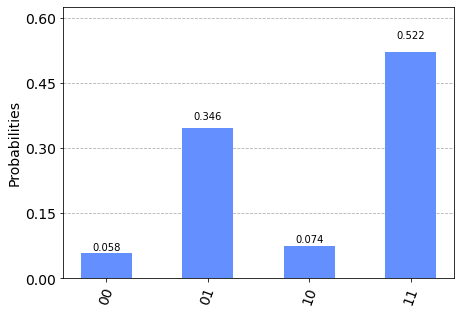

In [111]:

backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
counts2 = execute(qc2, backend, shots=1024).result().get_counts()


plot_histogram(counts2)

## References

https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

https://arxiv.org/pdf/1712.07326.pdf


## Trying more versions

## TRying https://arxiv.org/pdf/1202.1536.pdf

